In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from sklearn.preprocessing import MinMaxScaler

## **Dataset cleaning and Analysis**

**Cleaning Dataset**

In [ ]:
import pandas as pd

df = pd.read_csv('dataset.csv')
df = df.drop(columns=['Adj Close'])
df['nextclose'] = df['Close'].shift(-1)
df = df.dropna(subset=['nextclose'])
df.to_csv('updated_dataset.csv', index=False)

**analyzing dataset**

In [ ]:
def analyze_dataset(df):
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            print(f"Column: {col}")
            print(f"  Count: {df[col].count()}")
            print(f"  Min: {df[col].min()}")
            print(f"  Max: {df[col].max()}")
            print(f"  Mean: {df[col].mean()}")
            print(f"  Median: {df[col].median()}")
            print(f"  Standard Deviation: {df[col].std()}")
            print(f"  Variance: {df[col].var()}")
            print("-" * 40)

df = pd.read_csv('updated_dataset.csv')
print("\nSummary Statistics:\n")
analyze_dataset(df)


Summary Statistics:

Column: Open
  Count: 14662
  Min: 3.652559996
  Max: 115.0075836
  Mean: 26.98412813802885
  Median: 19.27206039
  Standard Deviation: 24.957318256416116
  Variance: 622.8677345520412
----------------------------------------
Column: High
  Count: 14662
  Min: 3.720644951
  Max: 117.194313
  Mean: 27.34656708093937
  Median: 19.48833084
  Standard Deviation: 25.328511768234954
  Variance: 641.5335083936166
----------------------------------------
Column: Low
  Count: 14662
  Min: 3.604500055
  Max: 111.8836823
  Mean: 26.595309313547673
  Median: 19.01974487
  Standard Deviation: 24.544566320582604
  Variance: 602.4357358654779
----------------------------------------
Column: Close
  Count: 14662
  Min: 3.652559996
  Max: 113.7820511
  Mean: 26.970569543734552
  Median: 19.27206039
  Standard Deviation: 24.93846505237753
  Variance: 621.9270391686555
----------------------------------------
Column: Volume
  Count: 14662
  Min: 0
  Max: 100751600
  Mean: 2617373.95

## **ANFIS Pipeline Implementaion**

##### **Membership Functions**

In [ ]:
def s_shape(x, c, alpha):
    res = 1 / (1 + np.exp(-alpha * (x - c)))
    return res

def z_shape(x, c, alpha):
    res = 1 / (1 + np.exp(alpha * (x - c)))
    return res

def gaussian(x, c, sigma):
    return np.exp(-((x - c) ** 2) / (2 * sigma ** 2))

In [ ]:
def apply_membership_functions_chromosome(x, mf_params, num_mfs):

    centers = sorted(mf_params['centers'])  # Sort the centers to ensure correct assignment of centers to MFs
    alphas = mf_params['alphas']
    sigmas = mf_params['sigmas']

    mfs = []

    # S-shape
    mfs.append(s_shape(x, centers[0], alphas[0]))

    # Gaussian membership functions
    for i in range(1, num_mfs - 1):
        mfs.append(gaussian(x, centers[i], sigmas[i - 1]))

    # Z-shape
    mfs.append(z_shape(x, centers[-1], alphas[1]))

    return np.array(mfs)


##### **layers**

In [ ]:
def fuzzification_layer(mf_params_dict):
    fuzzified_values = []
    for i, feat in enumerate(features):
        mf_params = mf_params_dict[feat]
        mfs = apply_membership_functions_chromosome(input_data[:, i], mf_params, num_parts[feat])
        fuzzified_values.append(mfs)
    return np.array(fuzzified_values)

In [ ]:
def rule_layer(fuzzified_values):
    # print('fuzzified_values: ',fuzzified_values.shape)
    # (5, 4, 14662)
    return np.prod(fuzzified_values, axis=0)  # Product over features

In [ ]:
def normalization_layer(firing_strengths):
    # print('firing_strengths: ',firing_strengths.shape)
    # (4, 14662)
    sum_firing = np.sum(firing_strengths, axis=0, keepdims=True)
    sum_firing[sum_firing == 0] = 1
    norm_firing_strengths = firing_strengths / sum_firing
    return norm_firing_strengths

In [ ]:
def defuzzification_layer(norm_firing_strengths, coefficients):
    # print('norm_firing_strengths: ',norm_firing_strengths.shape)
    # (4, 14662)
    # print('coefficients: ',len(coefficients))
    # (4, 1)

    weighted_output = np.dot(coefficients, norm_firing_strengths)
    return weighted_output

## **Genetic Algorithm**

##### **Chromosome Class**

In [ ]:
class Chromosome:
    def __init__(self):
        self.features = features
        self.num_parts = num_parts
        self.num_rules = num_rules
        self.mf_params = {}  # Store MF parameters per feature
        self.rule_coefficients = []  # Store rule coefficients
        self.fitness = None
        # initialize with random numbers
        self._initialize_mf_params()
        self._initialize_rule_coefficients()

    def _initialize_mf_params(self):

        for feat in self.features:
            center_range = (0.1, 0.9)
            sigma_range = (0.01, 0.3)
            alpha_range = (0.5, 1.5)

            centers = [random.uniform(center_range[0], center_range[1]) for _ in range(self.num_parts[feat])]
            alphas = [random.uniform(alpha_range[0], alpha_range[1]) for _ in range(2)]
            sigmas = [random.uniform(sigma_range[0], sigma_range[1]) for _ in range(self.num_parts[feat] - 2)]

            self.mf_params[feat] = {
                'centers': centers,
                'alphas': alphas,
                'sigmas': sigmas
            }

    def _initialize_rule_coefficients(self):
        self.rule_coefficients = [random.uniform(1, 120) for _ in range(self.num_rules)]

    def evaluate(self):

        fuzzified_values = fuzzification_layer(self.mf_params)
        firing_strengths = rule_layer(fuzzified_values)
        norm_firing_strengths = normalization_layer(firing_strengths)
        final_output = defuzzification_layer(norm_firing_strengths, self.rule_coefficients)

        mse = np.mean((final_output - output_data) ** 2)
        self.fitness = mse
        return mse, final_output

    def __str__(self):
        s = "Chromosome Parameters:\n"
        for feat, params in self.mf_params.items():
            s += f"Feature: {feat}\n"
            s += f"  Centers: {params['centers']}\n"
            s += f"  Alphas: {params['alphas']}\n"
            s += f"  Sigmas: {params['sigmas']}\n"
        s += f"Rule Coefficients: {self.rule_coefficients}\n"
        s += f"Fitness: {self.fitness}\n"
        return s


##### **EA algoritms**

In [ ]:
def tournament_selection(population):

    contenders = random.sample(population, tournsize)
    return min(contenders, key=lambda ind: ind.fitness)

In [ ]:
def mateChromosomes(ind1, ind2):

    for feat in ind1.features:
        if random.random() < cx_rate:
            ind1.mf_params[feat]['centers'], ind2.mf_params[feat]['centers'] = \
                ind2.mf_params[feat]['centers'], ind1.mf_params[feat]['centers']
        if random.random() < cx_rate:
            ind1.mf_params[feat]['alphas'], ind2.mf_params[feat]['alphas'] = \
                ind2.mf_params[feat]['alphas'], ind1.mf_params[feat]['alphas']
        if random.random() < cx_rate:
            ind1.mf_params[feat]['sigmas'], ind2.mf_params[feat]['sigmas'] = \
                ind2.mf_params[feat]['sigmas'], ind1.mf_params[feat]['sigmas']
    for i in range(len(ind1.rule_coefficients)):
        if random.random() < cx_rate:
            ind1.rule_coefficients[i], ind2.rule_coefficients[i] = \
                ind2.rule_coefficients[i], ind1.rule_coefficients[i]
    return ind1, ind2

In [ ]:
def mutateChromosome(ind):
    for feat in ind.features:
        for i in range(len(ind.mf_params[feat]['centers'])):
            if random.random() < mutation_rate:
                ind.mf_params[feat]['centers'][i] += random.gauss(0, mutation_scale_feature)

        for i in range(len(ind.mf_params[feat]['alphas'])):
            if random.random() < mutation_rate:
                ind.mf_params[feat]['alphas'][i] += random.gauss(0, mutation_scale_feature)

        for i in range(len(ind.mf_params[feat]['sigmas'])):
            if random.random() < mutation_rate:
                ind.mf_params[feat]['sigmas'][i] += random.gauss(0, mutation_scale_feature)

    for i in range(len(ind.rule_coefficients)):
        if random.random() < mutation_rate:
            ind.rule_coefficients[i] += random.gauss(0, mutation_scale_coefficient)

    return (ind,)

In [ ]:
def evaluate_population(population):

    for ind in population:
        ind.evaluate()

In [ ]:
def run_ea_custom():
    # Initialize population
    population = [Chromosome() for _ in range(pop_size)]
    best_ind = None
    best_fitness = float('inf')

    for gen in range(n_gen):

        evaluate_population(population)
        current_best = min(population, key=lambda ind: ind.fitness)

        if current_best.fitness < best_fitness:
            best_fitness = current_best.fitness
            best_ind = copy.deepcopy(current_best)
        print(f"Generation {gen}: Best fitness = {best_fitness}")

        # Create new population
        new_population = []

        population_sorted = sorted(population, key=lambda ind: ind.fitness)
        new_population.extend(population_sorted[:2])

        while len(new_population) < pop_size:
            # Select parents via tournament selection
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)
            # Make deep copies of parents for offspring
            child1 = copy.deepcopy(parent1)
            child2 = copy.deepcopy(parent2)
            # Crossover with probability
            if random.random() < cxpb:
                mateChromosomes(child1, child2)
            # Mutate with probability
            if random.random() < mutpb:
                mutateChromosome(child1)
            if random.random() < mutpb:
                mutateChromosome(child2)
            new_population.extend([child1, child2])
        population = new_population[:pop_size]

    return best_ind

## **Main**

**Dataset Notmalization**

In [ ]:
df = pd.read_csv('updated_dataset.csv')
features = ['Open', 'High', 'Low', 'Close', 'Volume']
label = 'nextclose'

scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

**Preparing Input and Output**                                                  

In [ ]:
# global variables of this code

input_data = df[features].values
output_data = df[label].values

num_parts = {
    "Open": 4,
    "High": 4,
    "Low": 4,
    "Close": 4,
    "Volume": 4
}

num_rules = 4

pop_size = 90
n_gen = 50
tournsize = 3

cxpb = 0.8
cx_rate = 0.5

mutpb = 0.25 # برای آن فرزند میوتیشن رخ دهد یا خیر؟
mutation_rate = 0.15 # حالا که قراره برای اون فرزند میوتیشن رخ بده، از این برای این استفاده میکنیم که کدام پارامترها انتخاب بشن؟
mutation_scale_feature = 0.01
mutation_scale_coefficient = 1.2

**Run Evolutionary Algorithm**

In [ ]:
best_individual = run_ea_custom()
best_mse, best_predictions = best_individual.evaluate()

Generation 0: Best fitness = 49.39365484066901
Generation 1: Best fitness = 49.39365484066901
Generation 2: Best fitness = 49.39365484066901
Generation 3: Best fitness = 24.676878450676085
Generation 4: Best fitness = 24.676878450676085
Generation 5: Best fitness = 24.676878450676085
Generation 6: Best fitness = 24.676878450676085
Generation 7: Best fitness = 20.932600328690853
Generation 8: Best fitness = 16.24807198841712
Generation 9: Best fitness = 15.61652277636931
Generation 10: Best fitness = 13.05814346447717
Generation 11: Best fitness = 13.05814346447717
Generation 12: Best fitness = 9.147347554893317
Generation 13: Best fitness = 8.712823829167391
Generation 14: Best fitness = 8.327040787782295
Generation 15: Best fitness = 6.757272398869842
Generation 16: Best fitness = 6.757272398869842
Generation 17: Best fitness = 6.757272398869842
Generation 18: Best fitness = 6.750647149355639
Generation 19: Best fitness = 6.728411238761958
Generation 20: Best fitness = 6.7053600516353

In [ ]:
print("Best Chromosome:")
print(best_individual)
print("Best MSE:", best_mse)

Best Chromosome:
Chromosome Parameters:
Feature: Open
  Centers: [0.46647033122744913, 0.7902605614465875, 0.7421685164249305, 0.16212787085010139]
  Alphas: [1.462378823839952, 1.0786905508517866]
  Sigmas: [0.24065436212456565, 0.09993401239616291]
Feature: High
  Centers: [0.3355067378232903, 0.2004358620904182, 0.239203321629173, 0.38625117706259815]
  Alphas: [1.515717676490809, 1.0987276326194069]
  Sigmas: [0.21098988407245162, 0.24113756796986438]
Feature: Low
  Centers: [0.7453100771864285, 0.47400955331106603, 0.8035857052422172, 0.7014441374904207]
  Alphas: [1.4697865286775362, 1.0678352763962777]
  Sigmas: [0.09896093041845719, 0.16290025169709216]
Feature: Close
  Centers: [0.10011837943878762, 0.3727151410923926, 0.19612137410220645, 0.3627129651156262]
  Alphas: [1.2202927388083875, 1.3585389062348663]
  Sigmas: [0.18955002623652145, 0.1254763464282468]
Feature: Volume
  Centers: [0.7313579316110858, 0.6193785609906839, 0.5295850890608842, 0.17443210046722696]
  Alphas:

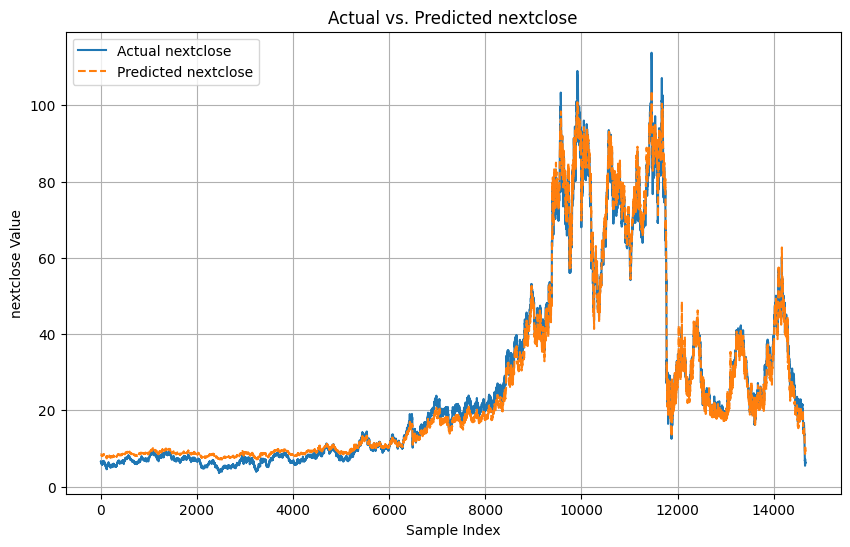

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(output_data, label='Actual nextclose')
plt.plot(best_predictions, label='Predicted nextclose', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('nextclose Value')
plt.title('Actual vs. Predicted nextclose')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
comparison_df = pd.DataFrame({
    'Actual nextclose': output_data,
    'Predicted nextclose': best_predictions
})
comparison_df

,Actual nextclose,Predicted nextclose
0,6.632280,8.411703
1,6.632280,8.435950
2,6.624270,8.469323
3,6.408000,8.463814
4,6.355935,8.388258
...,...,...
14657,6.840000,10.268700
14658,6.550000,9.929153
14659,6.070000,9.396795
14660,6.160000,9.253355
